## นับจำนวน Data

In [ ]:

import os

DATA_ROOT = "C:\\Users\\huaih\\Downloads\\Finally_AI_V2\\ai\\USE_T_DATA224\\train"  # เปลี่ยน path ตามจริง
classes = ['Plastic_bottle', 'Unknown', 'general_trash', 'glass', 'hazardous_waste']
IMAGE_EXTENSIONS = ('.jpg', '.jpeg', '.png')

for class_name in classes:
    class_folder = os.path.join(DATA_ROOT, class_name)
    if os.path.exists(class_folder):
        num_images = len([f for f in os.listdir(class_folder) if f.lower().endswith(IMAGE_EXTENSIONS)])
        print(f"{class_name} : {num_images} images")
    else:
        print(f"{class_name} :  โฟลเดอร์ไม่พบ")



Plastic_bottle : 354 images
Unknown : 358 images
general_trash : 370 images
glass : 338 images
hazardous_waste : 370 images


# 1 IMPORT & SETUP

In [27]:
# ====================================================
# #1 IMPORT & SETUP
# ====================================================
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# sklearn (optional)
try:
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
    SKLEARN_AVAILABLE = True
except Exception:
    SKLEARN_AVAILABLE = False
    
print("Library Versions")
print(f"Python version       : {os.sys.version}")
print(f"TensorFlow version   : {tf.__version__}")
print(f"Keras version        : {keras.__version__}")
print(f"Numpy version        : {np.__version__}")
print(f"Matplotlib version   : {matplotlib.__version__}")

Library Versions
Python version       : 3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]
TensorFlow version   : 2.19.0
Keras version        : 3.10.0
Numpy version        : 2.0.2
Matplotlib version   : 3.10.0


# 2 CONFIGURATION (ปรับเพื่อลด overfitting)

In [28]:
# ====================================================
# #2 CONFIGURATION (ปรับเพื่อลด overfitting)
# ====================================================
CONFIG = {
    'DATA_ROOT': 'C:\\Users\\huaih\\Downloads\\Finally_AI_V2\\ai\\USE_T_DATA224',  # เปลี่ยน path ตามจริง
    'TRAIN_SUBFOLDER': 'train',
    'VAL_SUBFOLDER': 'val',     #  เพิ่มโฟลเดอร์ validation
    'TEST_SUBFOLDER': 'test',

    'IMAGE_SIZE': (224, 224),
    'BATCH_SIZE': 16,             #  ลด batch size จาก 32 → 16
    'INITIAL_EPOCHS': 10,
    'FINE_TUNE_EPOCHS': 5,
    'BASE_LEARNING_RATE': 1e-4,   #  ลด learning rate
    'FINE_TUNE_LR_FACTOR': 0.2,
    'DROPOUT_RATE': 0.5,          #  เพิ่ม dropout
    'FINE_TUNE_AT': 30,           #  ปลดล็อกน้อยลงตอน fine-tune

    # -------------------------
    # Regularization / Overfitting control
    # -------------------------
    'DROPOUT_RATE': 0.5,            # เพิ่ม dropout ลด overfit
    'L2_REGULARIZATION': 0.001,     # เพิ่ม L2 penalty ใน Dense layer
    'LABEL_SMOOTHING': 0.1,         # label smoothing ลด overconfidence
    'EARLYSTOP_PATIENCE': 5,        # EarlyStopping patience
    'REDUCE_LR_PATIENCE': 3,        # ReduceLROnPlateau patience

    'MODEL_DIR': 'C:\\Users\\huaih\\Downloads\\Finally_AI_V2\\ai\\model',
    'SAVE_MODEL_NAME': 'KLEENEX_model_v3.h5'
}

os.makedirs(CONFIG['MODEL_DIR'], exist_ok=True)
print(" Model checkpoints will be saved to:", CONFIG['MODEL_DIR'])

 Model checkpoints will be saved to: C:\Users\huaih\Downloads\Finally_AI_V2\ai\model


# 3 LOAD DATA (เพิ่ม validation และ data augmentation)

In [29]:
# ====================================================
# #3 LOAD DATA (เพิ่ม validation และ data augmentation)
# ====================================================
train_dir = os.path.join(CONFIG['DATA_ROOT'], CONFIG['TRAIN_SUBFOLDER'])
val_dir   = os.path.join(CONFIG['DATA_ROOT'], CONFIG['VAL_SUBFOLDER'])
test_dir  = os.path.join(CONFIG['DATA_ROOT'], CONFIG['TEST_SUBFOLDER'])

#  Data Augmentation เข้มขึ้น
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # normalize 0-1
    rotation_range=30,               # หมุนภาพ ±30 องศา
    width_shift_range=0.2,           # shift แนวนอน ±20%
    height_shift_range=0.2,          # shift แนวตั้ง ±20%
    shear_range=0.2,                 # shear transform
    zoom_range=0.2,                  # zoom
    horizontal_flip=True,            # พลิกซ้าย-ขวา
    fill_mode='nearest'              # เติมพิกเซลขอบภาพ
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=CONFIG['IMAGE_SIZE'],
    batch_size=CONFIG['BATCH_SIZE'],
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=CONFIG['IMAGE_SIZE'],
    batch_size=CONFIG['BATCH_SIZE'],
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=CONFIG['IMAGE_SIZE'],
    batch_size=CONFIG['BATCH_SIZE'],
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print(" Detected", num_classes, "classes:", train_generator.class_indices)

Found 1790 images belonging to 5 classes.
Found 276 images belonging to 5 classes.
Found 143 images belonging to 5 classes.
 Detected 5 classes: {'Plastic_bottle': 0, 'Unknown': 1, 'general_trash': 2, 'glass': 3, 'hazardous_waste': 4}


# 4 BUILD MODEL (เพิ่ม L2 regularization)

In [30]:
# ====================================================
# #4 BUILD MODEL (เพิ่ม L2 regularization)
# ====================================================
base_model = tf.keras.applications.MobileNetV2(
    input_shape=CONFIG['IMAGE_SIZE'] + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(CONFIG['DROPOUT_RATE']),
    layers.Dense(
        num_classes,
        activation='softmax',
        kernel_regularizer=keras.regularizers.l2(0.001)
    )
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CONFIG['BASE_LEARNING_RATE']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# 5 TRAIN & FINE-TUNE MODEL (เพิ่ม callback)

In [31]:
# ====================================================
# #5 TRAIN & FINE-TUNE MODEL (เพิ่ม callback)
# ====================================================
checkpoint_path = os.path.join(CONFIG['MODEL_DIR'], 'best_checkpoint_phase1.h5')

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

earlystop_cb = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

#  ลด learning rate อัตโนมัติถ้า val loss ไม่ดีขึ้น
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# ---------------------------
# PHASE 1: เทรนเฉพาะ Head
# ---------------------------
print("\n Starting Phase 1 Training...\n")
history = model.fit(
    train_generator,
    epochs=CONFIG['INITIAL_EPOCHS'],
    validation_data=val_generator,   #  ใช้ validation แทน test
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

# ---------------------------
# PHASE 2: Fine-tune Base Model
# ---------------------------
base_model.trainable = True
for layer in base_model.layers[:-CONFIG['FINE_TUNE_AT']]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=CONFIG['BASE_LEARNING_RATE'] * CONFIG['FINE_TUNE_LR_FACTOR']
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_path_phase2 = os.path.join(CONFIG['MODEL_DIR'], 'best_checkpoint_phase2.h5')
checkpoint_cb2 = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_phase2,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

print("\n Starting Fine-tuning...\n")
history_fine = model.fit(
    train_generator,
    epochs=CONFIG['FINE_TUNE_EPOCHS'],
    validation_data=val_generator,
    callbacks=[checkpoint_cb2, earlystop_cb, reduce_lr]
)

# ---------------------------
# SAVE FINAL MODEL
# ---------------------------
final_model_path = os.path.join(CONFIG['MODEL_DIR'], CONFIG['SAVE_MODEL_NAME'])
model.save(final_model_path)
print(f"\n Final model saved to: {final_model_path}")


 Starting Phase 1 Training...



c:\Users\huaih\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.1523 - loss: 2.5353
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to C:\Users\huaih\Downloads\Finally_AI_V2\ai\model\best_checkpoint_phase1.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 54s 455ms/step - accuracy: 0.1527 - loss: 2.5330 - val_accuracy: 0.3333 - val_loss: 1.5667 - learning_rate: 1.0000e-04
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.2841 - loss: 1.7742
Epoch 2: val_accuracy improved from 0.33333 to 0.64130, saving model to C:\Users\huaih\Downloads\Finally_AI_V2\ai\model\best_checkpoint_phase1.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 31s 281ms/step - accuracy: 0.2846 - loss: 1.7732 - val_accuracy: 0.6413 - val_loss: 1.0825 - learning_rate: 1.0000e-04
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.4778 - loss: 1.3531
Epoch 3: val_accuracy improved from 0.64130 to 0.77899, saving model to C:\Users\huaih\Downloads\Finally_AI_V2\ai\model\best_checkpoint_phase1.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 31s 278ms/step - accuracy: 0.4781 - loss: 1.3522 - val_accuracy: 0.7790 - val_loss: 0.7688 - learning_rate: 1.0000e-04
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.5735 - loss: 1.0912
Epoch 4: val_accuracy improved from 0.77899 to 0.88406, saving model to C:\Users\huaih\Downloads\Finally_AI_V2\ai\model\best_checkpoint_phase1.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 32s 287ms/step - accuracy: 0.5737 - loss: 1.0907 - val_accuracy: 0.8841 - val_loss: 0.5688 - learning_rate: 1.0000e-04
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.6803 - loss: 0.8468
Epoch 5: val_accuracy improved from 0.88406 to 0.93478, saving model to C:\Users\huaih\Downloads\Finally_AI_V2\ai\model\best_checkpoint_phase1.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 33s 291ms/step - accuracy: 0.6803 - loss: 0.8466 - val_accuracy: 0.9348 - val_loss: 0.4488 - learning_rate: 1.0000e-04
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.7037 - loss: 0.7767
Epoch 6: val_accuracy improved from 0.93478 to 0.96014, saving model to C:\Users\huaih\Downloads\Finally_AI_V2\ai\model\best_checkpoint_phase1.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 32s 286ms/step - accuracy: 0.7040 - loss: 0.7761 - val_accuracy: 0.9601 - val_loss: 0.3573 - learning_rate: 1.0000e-04
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.7791 - loss: 0.6215
Epoch 7: val_accuracy did not improve from 0.96014
112/112 ━━━━━━━━━━━━━━━━━━━━ 32s 287ms/step - accuracy: 0.7793 - loss: 0.6213 - val_accuracy: 0.9565 - val_loss: 0.3016 - learning_rate: 1.0000e-04
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.8345 - loss: 0.5179
Epoch 8: val_accuracy improved from 0.96014 to 0.96739, saving model to C:\Users\huaih\Downloads\Finally_AI_V2\ai\model\best_checkpoint_phase1.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 33s 292ms/step - accuracy: 0.8346 - loss: 0.5178 - val_accuracy: 0.9674 - val_loss: 0.2516 - learning_rate: 1.0000e-04
Epoch 9/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8407 - loss: 0.4754
Epoch 9: val_accuracy improved from 0.96739 to 0.97101, saving model to C:\Users\huaih\Downloads\Finally_AI_V2\ai\model\best_checkpoint_phase1.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 33s 295ms/step - accuracy: 0.8408 - loss: 0.4752 - val_accuracy: 0.9710 - val_loss: 0.2192 - learning_rate: 1.0000e-04
Epoch 10/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.8689 - loss: 0.4184
Epoch 10: val_accuracy did not improve from 0.97101
112/112 ━━━━━━━━━━━━━━━━━━━━ 31s 275ms/step - accuracy: 0.8690 - loss: 0.4182 - val_accuracy: 0.9710 - val_loss: 0.1906 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.

 Starting Fine-tuning...

Epoch 1/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.6307 - loss: 0.9604
Epoch 1: val_accuracy improved from -inf to 0.97826, saving model to C:\Users\huaih\Downloads\Finally_AI_V2\ai\model\best_checkpoint_phase2.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 334ms/step - accuracy: 0.6318 - loss: 0.9580 - val_accuracy: 0.9783 - val_loss: 0.1050 - learning_rate: 2.0000e-05
Epoch 2/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9150 - loss: 0.2964
Epoch 2: val_accuracy did not improve from 0.97826
112/112 ━━━━━━━━━━━━━━━━━━━━ 37s 329ms/step - accuracy: 0.9150 - loss: 0.2961 - val_accuracy: 0.9783 - val_loss: 0.0819 - learning_rate: 2.0000e-05
Epoch 3/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9483 - loss: 0.1959
Epoch 3: val_accuracy did not improve from 0.97826
112/112 ━━━━━━━━━━━━━━━━━━━━ 36s 318ms/step - accuracy: 0.9484 - loss: 0.1958 - val_accuracy: 0.9783 - val_loss: 0.0698 - learning_rate: 2.0000e-05
Epoch 4/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9647 - loss: 0.1569
Epoch 4: val_accuracy improved from 0.97826 to 0.98913, saving model to C:\Users\huaih\Downloads\Finally_AI_V2\ai\model\best_checkpoint_phase2.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 36s 319ms/step - accuracy: 0.9647 - loss: 0.1567 - val_accuracy: 0.9891 - val_loss: 0.0508 - learning_rate: 2.0000e-05
Epoch 5/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9763 - loss: 0.1098
Epoch 5: val_accuracy did not improve from 0.98913
112/112 ━━━━━━━━━━━━━━━━━━━━ 36s 323ms/step - accuracy: 0.9763 - loss: 0.1099 - val_accuracy: 0.9891 - val_loss: 0.0420 - learning_rate: 2.0000e-05
Restoring model weights from the end of the best epoch: 5.



 Final model saved to: C:\Users\huaih\Downloads\Finally_AI_V2\ai\model\KLEENEX_model_v3.h5


# 6 EVALUATE MODEL

In [32]:
# ====================================================
# #6 EVALUATE MODEL
# ====================================================
loss, acc = model.evaluate(test_generator)
print(f"\n Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 1.0000 - loss: 0.0351

 Test Accuracy: 1.0000, Test Loss: 0.0367


# 7 VISUALIZATION

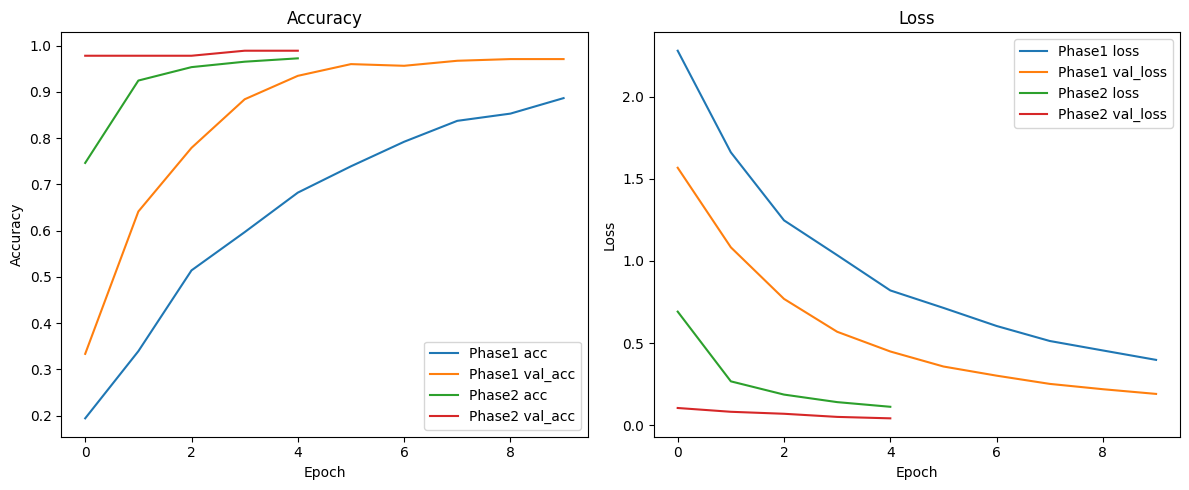

In [33]:
# ====================================================
# #7 VISUALIZATION
# ====================================================
def plot_history(histories, titles):
    plt.figure(figsize=(12,5))
    for i, history in enumerate(histories):
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label=f'{titles[i]} acc')
        plt.plot(history.history['val_accuracy'], label=f'{titles[i]} val_acc')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label=f'{titles[i]} loss')
        plt.plot(history.history['val_loss'], label=f'{titles[i]} val_loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_history([history, history_fine], ["Phase1", "Phase2"])

# 8 CONFUSION MATRIX (optional)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step

Classification Report:
                 precision    recall  f1-score   support

 Plastic_bottle       1.00      1.00      1.00        25
        Unknown       1.00      1.00      1.00        42
  general_trash       1.00      1.00      1.00        26
          glass       1.00      1.00      1.00        24
hazardous_waste       1.00      1.00      1.00        26

       accuracy                           1.00       143
      macro avg       1.00      1.00      1.00       143
   weighted avg       1.00      1.00      1.00       143



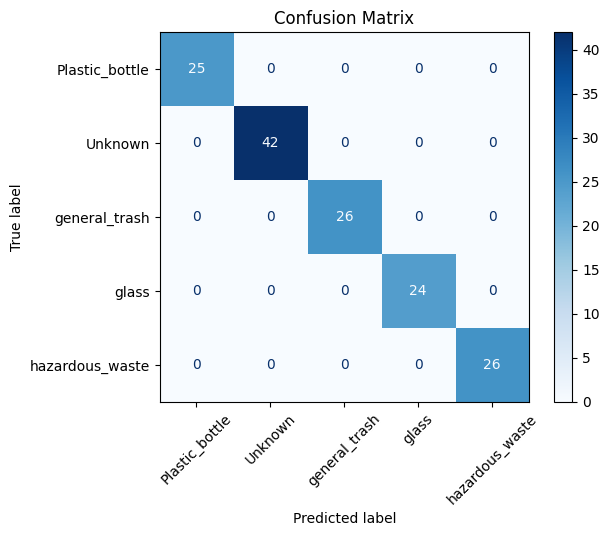

In [34]:
# ====================================================
# #8 CONFUSION MATRIX (optional)
# ====================================================
if SKLEARN_AVAILABLE:
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred_classes)
    ConfusionMatrixDisplay(cm, display_labels=class_labels).plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()
else:
    print("sklearn ไม่พร้อมใช้งาน — ข้าม confusion matrix")

 Loaded model from: C:\Users\huaih\Downloads\Finally_AI_V2\ai\model\KLEENEX_model_v3.h5
Class labels: ['Plastic_bottle', 'Unknown', 'general_trash', 'glass', 'hazardous_waste']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step


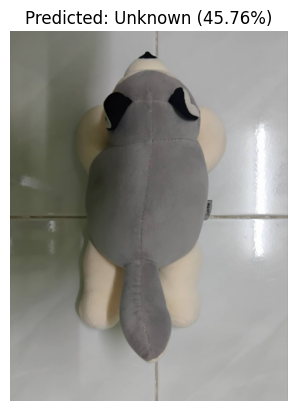

 Prediction: Unknown (confidence: 45.76%)


In [36]:

# ====================================================
# #9 LOAD MODEL & PREDICT NEW IMAGES
# ====================================================

import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

model_path = ("C:\\Users\\huaih\\Downloads\\Finally_AI_V2\\ai\\model\\KLEENEX_model_v3.h5") # เปลี่ยน path ตามจริง
model = load_model(model_path)
print(f" Loaded model from: {model_path}")

if 'train_generator' in globals():
    class_labels = list(train_generator.class_indices.keys())
    print("Class labels:", class_labels)
else:
    class_labels = ['class1', 'class2']  # <-- แก้ชื่อตามคลาส
    print(" train_generator ไม่เจอ ใช้ class_labels ที่กำหนดเอง:", class_labels)

def predict_image(img_path):
    img = image.load_img(img_path, target_size=CONFIG['IMAGE_SIZE'])
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    preds = model.predict(img_array)
    pred_idx = np.argmax(preds)
    pred_label = class_labels[pred_idx]
    confidence = preds[0][pred_idx]

    # แสดงภาพ + ผลทำนาย
    plt.imshow(image.load_img(img_path))
    plt.axis("off")
    plt.title(f"Predicted: {pred_label} ({confidence*100:.2f}%)")
    plt.show()

    print(f" Prediction: {pred_label} (confidence: {confidence*100:.2f}%)")

# ---------------------------
# ตัวอย่างการใช้งาน
# ---------------------------
# แก้ path ให้เป็นรูปใน Drive ของคุณ
sample_img = 'C:\\Users\\huaih\\Downloads\\Finally_AI_V2\\ai\\test_พิเศษ\\26408.jpg'
predict_image(sample_img)



# 10 MULTI-IMAGE PREDICTION (VISUALIZATION GRID)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


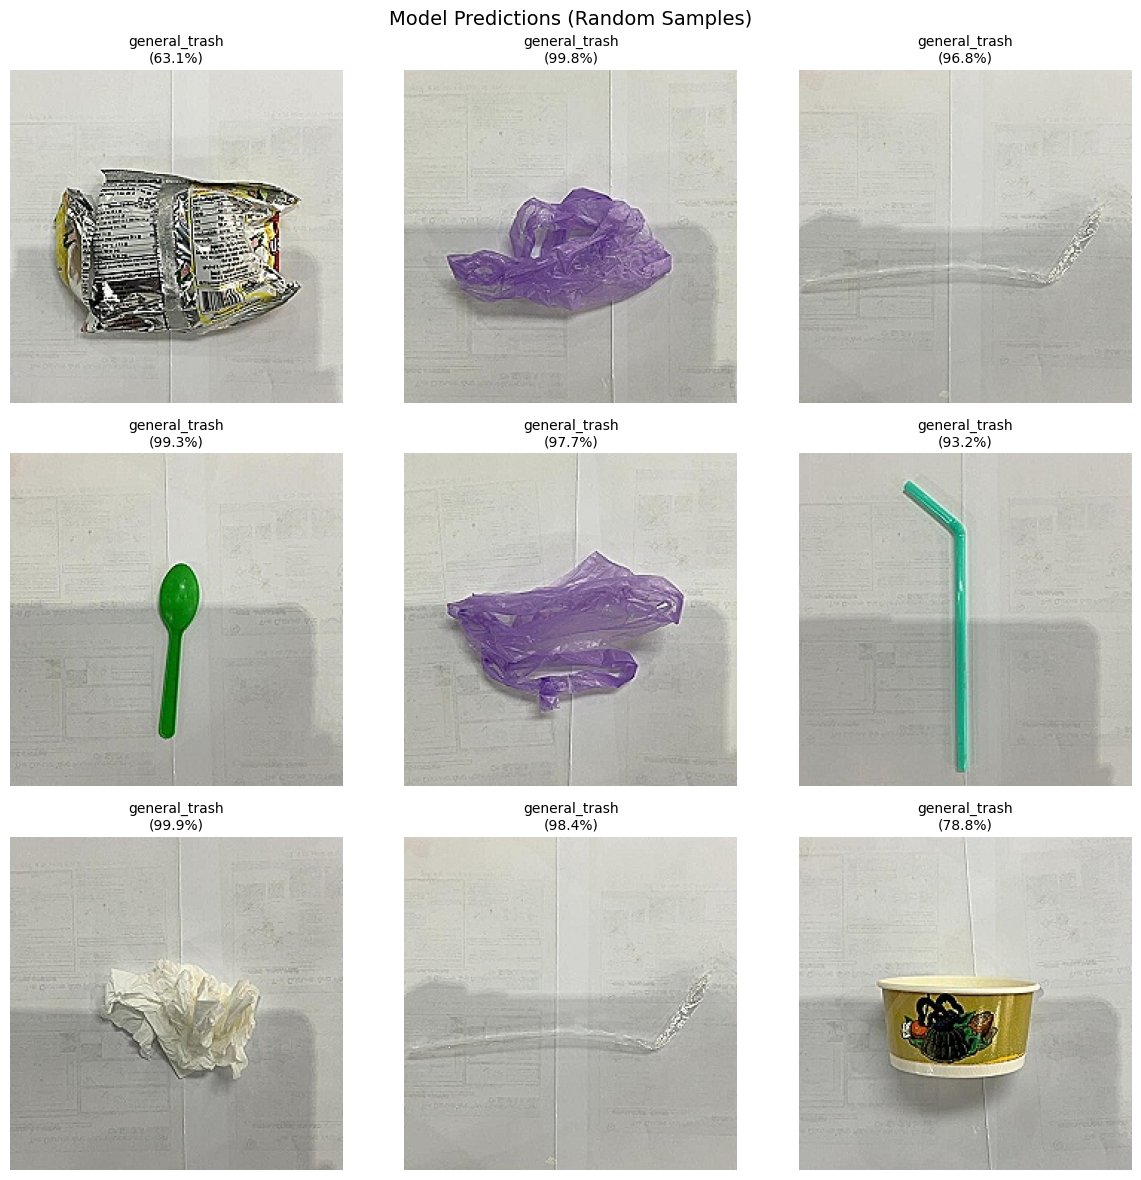

In [ ]:

# ====================================================
# #10 MULTI-IMAGE PREDICTION (VISUALIZATION GRID)
# ====================================================

import glob
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# เปลี่ยน path ให้ตรงกับโฟลเดอร์รูปภาพ
test_images_path = 'C:\\Users\\huaih\\Downloads\\Finally_AI_V2\\ai\\USE_T_DATA224\\test\\general_trash' # เปลี่ยน path ตามจริง
img_paths = glob.glob(os.path.join(test_images_path, '*.jpg'))

# สุ่มเลือกภาพมาแสดง (9 รูป)
sample_paths = random.sample(img_paths, min(9, len(img_paths)))

def predict_label(img_path):
    img = image.load_img(img_path, target_size=CONFIG['IMAGE_SIZE'])
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    preds = model.predict(img_array)
    pred_idx = np.argmax(preds)
    label = class_labels[pred_idx]
    confidence = preds[0][pred_idx]
    return label, confidence

plt.figure(figsize=(12, 12))
for i, path in enumerate(sample_paths):
    label, conf = predict_label(path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.load_img(path))
    plt.title(f"{label}\n({conf*100:.1f}%)", fontsize=10)
    plt.axis("off")

plt.suptitle("Model Predictions (Random Samples)", fontsize=14)
plt.tight_layout()
plt.show()



 # 11 RANDOM SAMPLE EVALUATION (AUTO DETECT CLASS FOLDERS)


ผลการทำนายสุ่ม 10 รูป
 ถูกต้อง 10 / 10 รูป  →  Accuracy = 100.00%


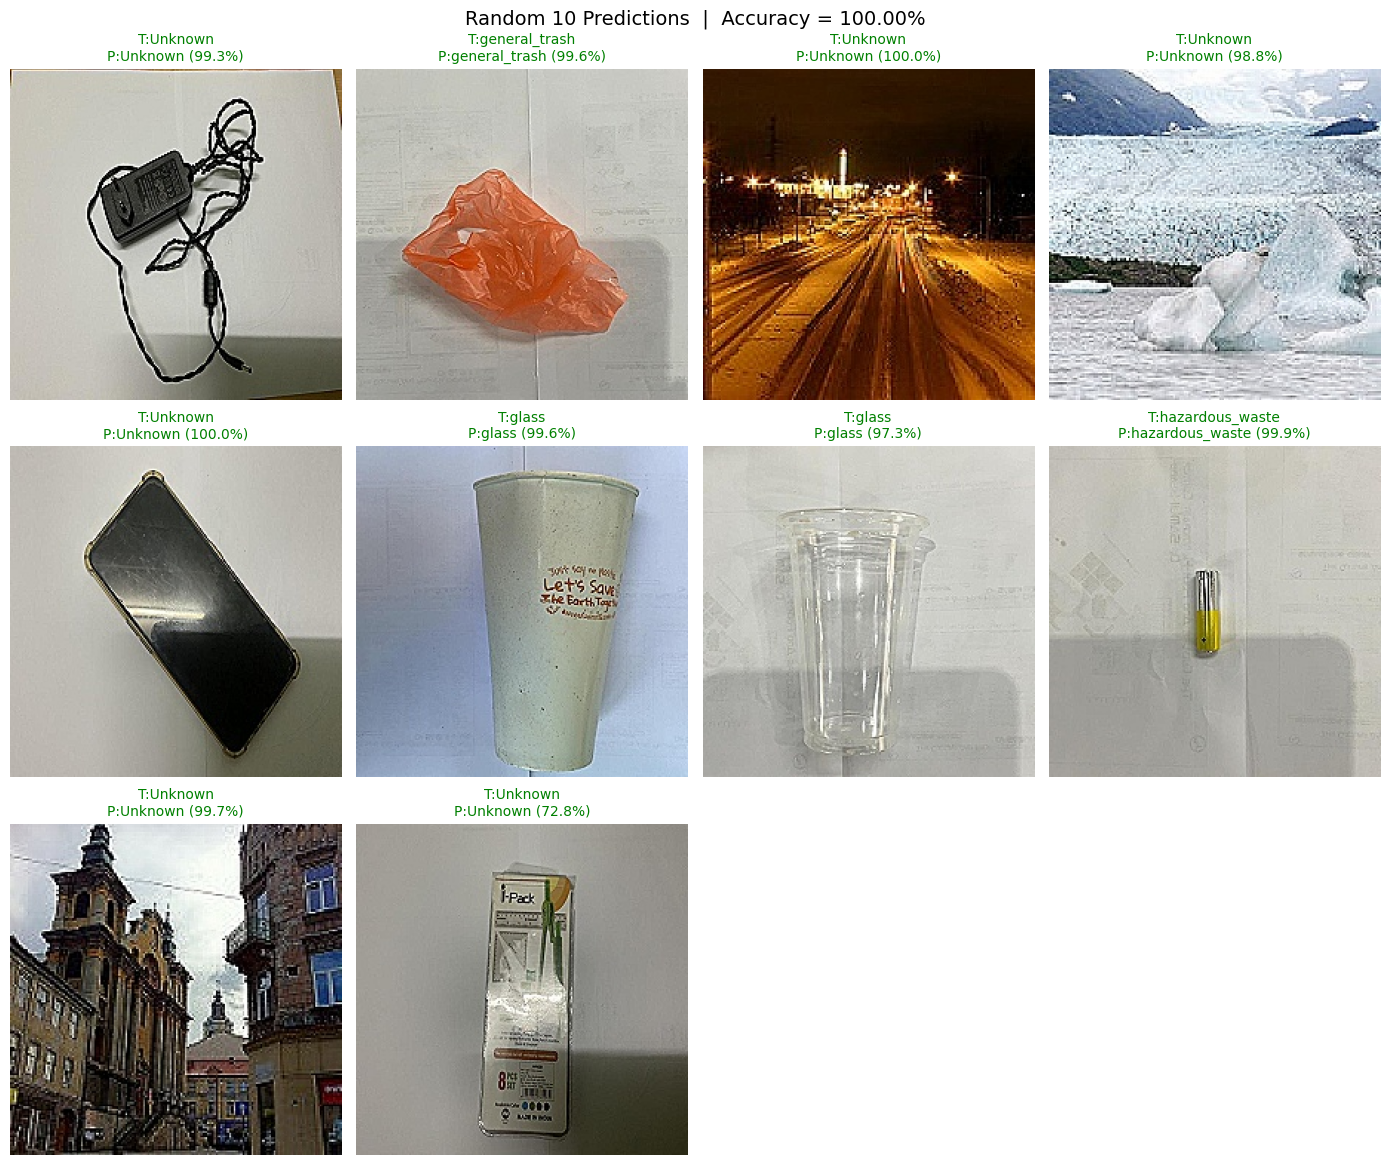

In [ ]:

# ====================================================
# #11 RANDOM SAMPLE EVALUATION (AUTO DETECT CLASS FOLDERS)
# ====================================================

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_label(img_path):
    img = image.load_img(img_path, target_size=CONFIG['IMAGE_SIZE'])
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    preds = model.predict(img_array, verbose=0)
    pred_idx = np.argmax(preds)
    label = class_labels[pred_idx]
    confidence = preds[0][pred_idx]
    return label, confidence

def evaluate_random_samples(test_folder_path, total_samples=100, show_examples=12):
    """
    test_folder_path: path ของโฟลเดอร์ test ที่มีโฟลเดอร์คลาสย่อย
    total_samples: จำนวนภาพทั้งหมดที่จะสุ่มมาทดสอบ (รวมทุกคลาส)
    show_examples: จำนวนภาพที่จะโชว์ในกริด (สุ่มจากชุดที่ทดสอบ)
    """
    class_folders = [d for d in os.listdir(test_folder_path)
                    if os.path.isdir(os.path.join(test_folder_path, d))]

    if not class_folders:
        print("ไม่พบโฟลเดอร์คลาสใน test path!")
        return

    all_images = []
    for class_name in class_folders:
        class_folder = os.path.join(test_folder_path, class_name)
        files = [os.path.join(class_folder, f) for f in os.listdir(class_folder)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        all_images.extend([(f, class_name) for f in files])

    if len(all_images) == 0:
        print("ไม่มีภาพใน test folder!")
        return

    sample_data = random.sample(all_images, min(total_samples, len(all_images)))

    correct = 0
    results = []

    for img_path, true_label in sample_data:
        pred_label, conf = predict_label(img_path)
        is_correct = (pred_label == true_label)
        correct += is_correct
        results.append((img_path, true_label, pred_label, conf, is_correct))

    accuracy = (correct / len(sample_data)) * 100
    print(f"\nผลการทำนายสุ่ม {len(sample_data)} รูป")
    print(f" ถูกต้อง {correct} / {len(sample_data)} รูป  →  Accuracy = {accuracy:.2f}%")

    sample_to_show = random.sample(results, min(show_examples, len(results)))
    cols = 4
    rows = int(np.ceil(len(sample_to_show) / cols))

    plt.figure(figsize=(14, 4 * rows))
    for i, (path, true_label, pred_label, conf, is_correct) in enumerate(sample_to_show):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image.load_img(path))
        color = "green" if is_correct else "red"
        plt.title(f"T:{true_label}\nP:{pred_label} ({conf*100:.1f}%)", color=color, fontsize=10)
        plt.axis("off")

    plt.suptitle(f"Random {len(sample_data)} Predictions  |  Accuracy = {accuracy:.2f}%", fontsize=14)
    plt.tight_layout()
    plt.show()


# ---------------------------
# เรียกใช้งาน
# ---------------------------
test_folder = "C:\\Users\\huaih\\Downloads\\Finally_AI_V2\\ai\\USE_T_DATA224\\test" # เปลี่ยน path ตามจริง
evaluate_random_samples(test_folder, total_samples=10, show_examples=10)


# 12 test รูปอื่นๆๆ

 Loaded model from: C:\Users\huaih\Downloads\Finally_AI_V2\ai\KLEENEX_model_v3.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
 Image: 8.jpg
 Confidence top: 0.9527 | Margin: 0.9190
 Predicted: Unknown


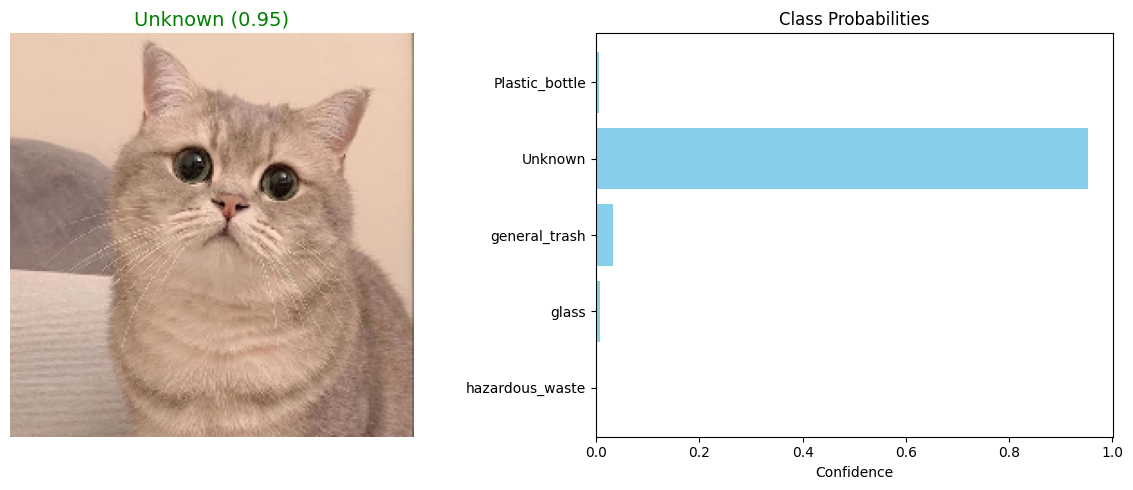

In [24]:

# ====================================================
# #12 TEST SINGLE IMAGE + UNKNOWN DETECTION (Improved)
# ====================================================
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

def load_trained_model(model_path):
    """โหลดโมเดลจากไฟล์ .h5"""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f" ไม่พบโมเดลที่: {model_path}")
    model = tf.keras.models.load_model(model_path)
    print(f" Loaded model from: {model_path}")
    return model

def predict_with_threshold(
    model,
    img_path,
    class_labels,
    threshold=0.7,
    margin=0.15,
    show_plot=True,
    img_size=(224, 224)
):
    """
    ฟังก์ชันทำนายภาพ พร้อมตรวจจับ Unknown โดยใช้ threshold + margin
    """
    if not os.path.exists(img_path):
        raise FileNotFoundError(f" ไม่พบไฟล์ภาพ: {img_path}")

    img = image.load_img(img_path, target_size=img_size)
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)

    pred = model.predict(x)
    pred = pred[0]
    top_idx = np.argmax(pred)
    top_prob = pred[top_idx]

    sorted_probs = np.sort(pred)[::-1]
    margin_diff = sorted_probs[0] - sorted_probs[1]

    if (top_prob < threshold) or (margin_diff < margin):
        label = "Unknown"
        color = "red"
    else:
        label = class_labels[top_idx]
        color = "green"

    print(" Image:", os.path.basename(img_path))
    print(f" Confidence top: {top_prob:.4f} | Margin: {margin_diff:.4f}")
    print(f" Predicted: {label}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{label} ({top_prob:.2f})", color=color, fontsize=14)
    
    if show_plot:
        plt.subplot(1, 2, 2)
        plt.barh(class_labels, pred, color="skyblue")
        plt.xlabel("Confidence")
        plt.title("Class Probabilities")
        plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()


# ====================================================
#  ตัวอย่างการใช้งาน
# ====================================================
# (เปลี่ยน path )
model_path = "C:\\Users\\huaih\\Downloads\\Finally_AI_V2\\ai\\KLEENEX_model_v3.h5"
model = load_trained_model(model_path)


class_labels = ['Plastic_bottle', 'Unknown', 'general_trash', 'glass', 'hazardous_waste']


test_image_path = "C:\\Users\\huaih\\Downloads\\Finally_AI_V2\\ai\\test_พิเศษ\\8.jpg"  # เปลี่ยน path ตามจริง


predict_with_threshold(
    model,
    test_image_path,
    class_labels=class_labels,
    threshold=0.65,   #  ปรับค่าได้
    margin=0.10       #  ถ้าโมเดลสับสน ให้เพิ่ม margin
)



# 13 RANDOM SAMPLE test พิเศษ

 Loaded model from: C:\Users\huaih\Downloads\Finally_AI_V2\ai\KLEENEX_model_v3.h5

 ผลการทำนายสุ่ม 18 รูป
images (2).jpg → Unknown (51.1%)
canva-MAEO-l70lIU.jpg → Unknown (91.8%)
26415.jpg → Unknown (99.9%)
S__21446693.jpg → Plastic_bottle (100.0%)
S__21446694.jpg → glass (88.6%)
26413.jpg → Unknown (74.4%)
26405.jpg → Unknown (99.3%)
26404.jpg → Unknown (98.7%)
26409.jpg → general_trash (66.5%)
26407.jpg → Unknown (81.7%)
S__21520429.jpg → Unknown (51.2%)
S__21446691.jpg → general_trash (82.8%)
S__21446690.jpg → Plastic_bottle (96.5%)
8.jpg → Unknown (95.3%)
download.jpg → Unknown (98.9%)
26406.jpg → Unknown (93.5%)
images.jpg → Unknown (87.1%)
26414.jpg → Unknown (86.8%)


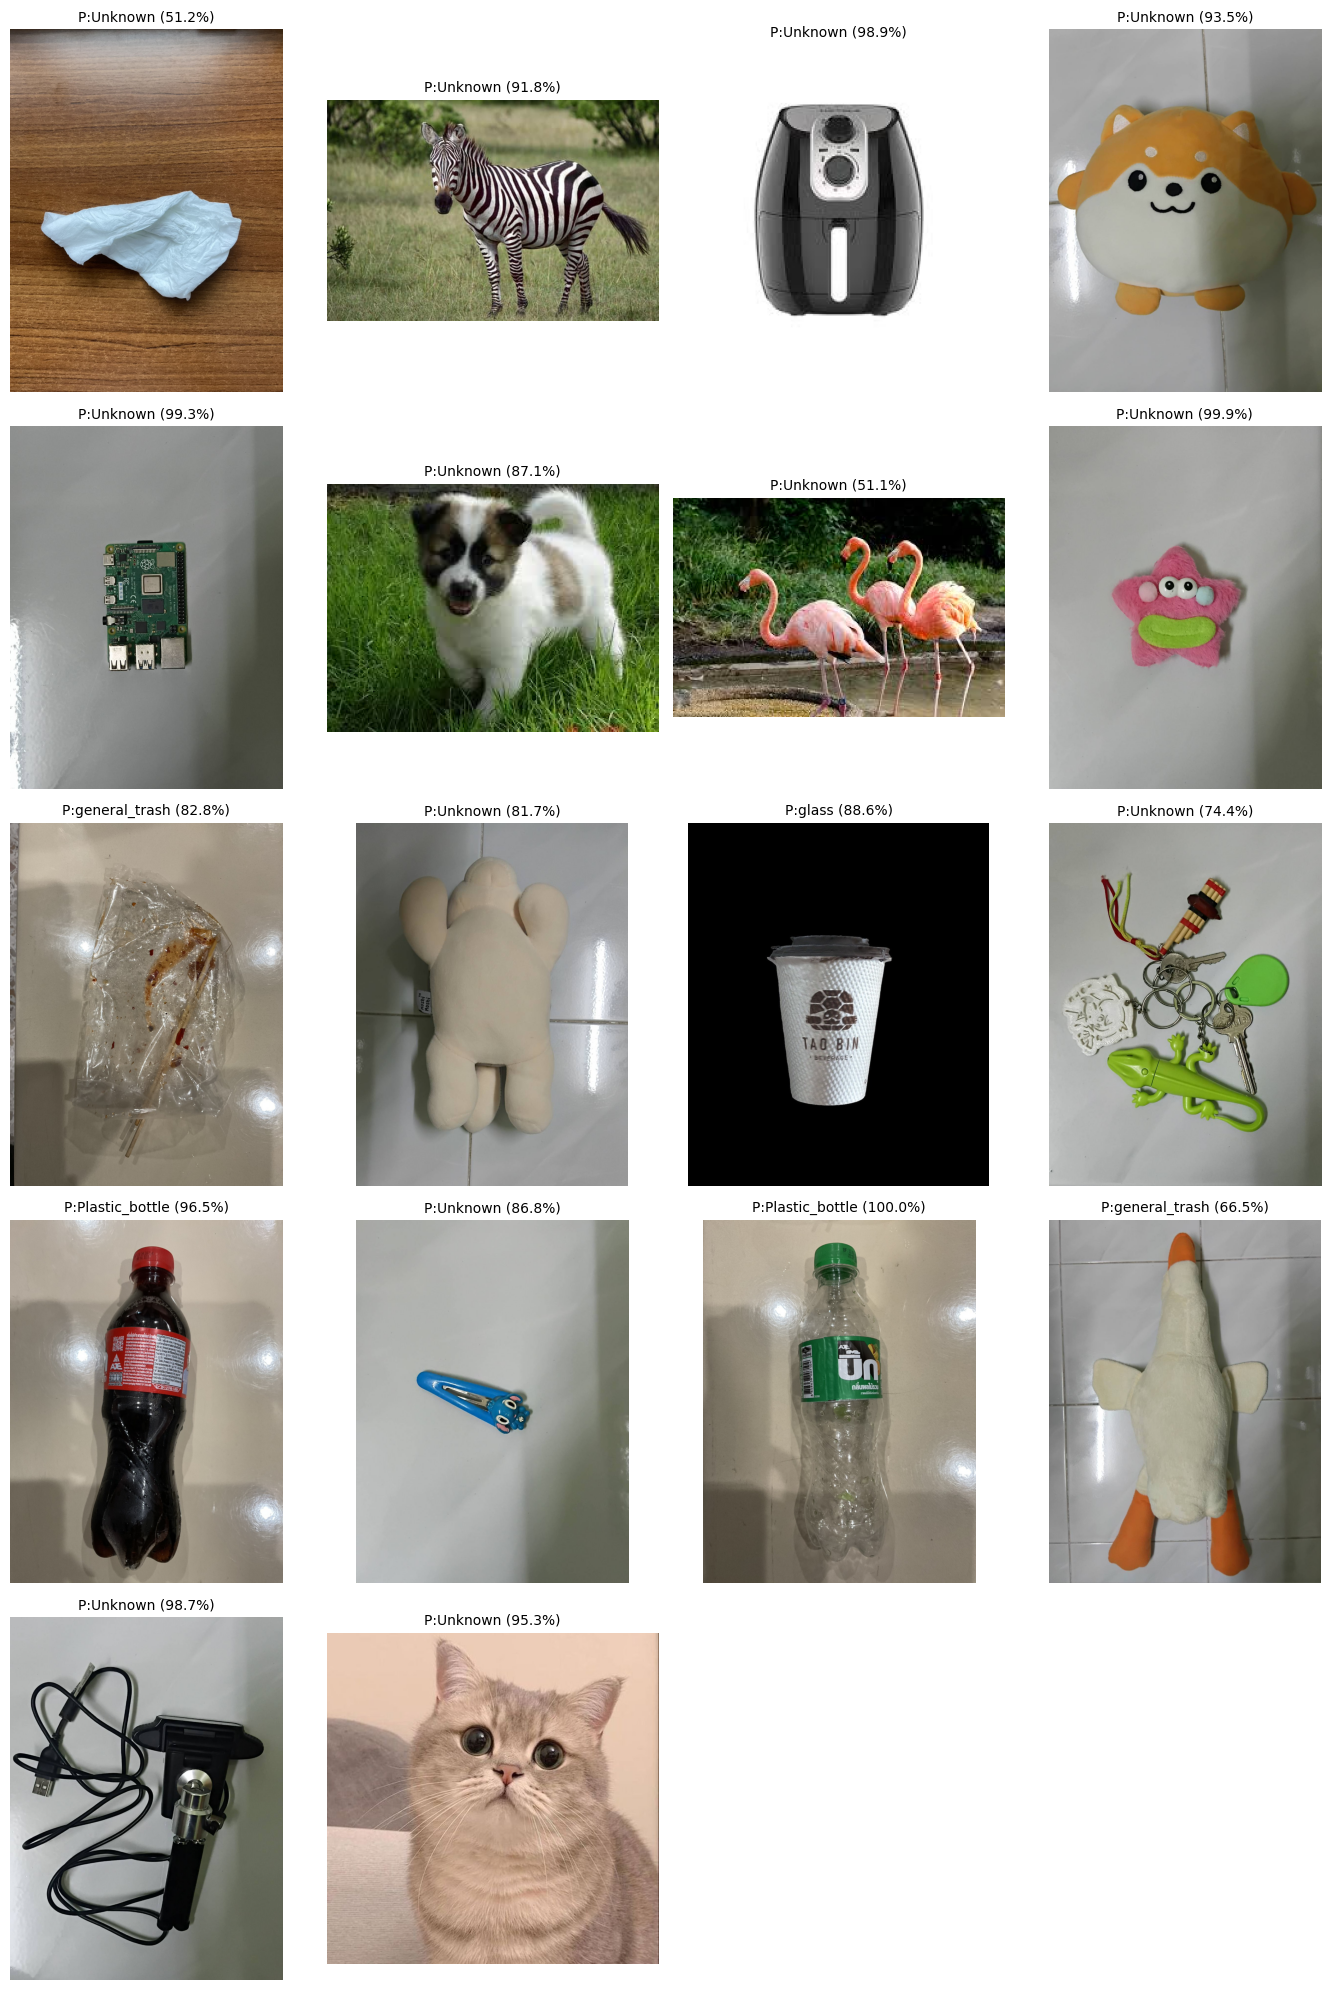

In [26]:

# ====================================================
# 13 RANDOM SAMPLE EVALUATION (WITH UNKNOWN DETECTION)
# ====================================================
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf

def load_trained_model(model_path):
    model = tf.keras.models.load_model(model_path)
    print(f" Loaded model from: {model_path}")
    return model

def predict_with_threshold_single(model, img_path, class_labels,
                                  threshold=0.7, margin=0.15, img_size=(224, 224)):
    img = image.load_img(img_path, target_size=img_size)
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)

    preds = model.predict(x, verbose=0)[0]
    top_idx = np.argmax(preds)
    top_prob = preds[top_idx]

    sorted_probs = np.sort(preds)[::-1]
    margin_diff = sorted_probs[0] - sorted_probs[1]

    if (top_prob < threshold) or (margin_diff < margin):
        label = "Unknown"
    else:
        label = class_labels[top_idx]

    return label, top_prob, preds

def evaluate_random_samples_with_unknown(model, test_folder_path, class_labels,
                                        total_samples=100, show_examples=12,
                                        threshold=0.7, margin=0.15):
    """
    ทดสอบภาพแบบสุ่มหลายภาพ พร้อมตรวจจับ Unknown
    """
    #  ดึงเฉพาะไฟล์ภาพในโฟลเดอร์นั้น (ไม่ต้องมี subfolder)
    all_images = [os.path.join(test_folder_path, f)
                  for f in os.listdir(test_folder_path)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if len(all_images) == 0:
        print(" ไม่มีภาพใน test folder!")
        return

    sample_data = random.sample(all_images, min(total_samples, len(all_images)))

    results = []
    for img_path in sample_data:
        pred_label, conf, preds = predict_with_threshold_single(
            model, img_path, class_labels, threshold, margin)
        results.append((img_path, pred_label, conf))

    print(f"\n ผลการทำนายสุ่ม {len(sample_data)} รูป")
    for path, label, conf in results:
        print(f"{os.path.basename(path)} → {label} ({conf*100:.1f}%)")

    sample_to_show = random.sample(results, min(show_examples, len(results)))
    cols = 4
    rows = int(np.ceil(len(sample_to_show) / cols))

    plt.figure(figsize=(14, 4 * rows))
    for i, (path, label, conf) in enumerate(sample_to_show):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image.load_img(path))
        plt.title(f"P:{label} ({conf*100:.1f}%)", fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# ====================================================
# ตัวอย่างเรียกใช้งาน
# ====================================================
if __name__ == "__main__":
    model_path = "C:\\Users\\huaih\\Downloads\\Finally_AI_V2\\ai\\KLEENEX_model_v3.h5"
    model = load_trained_model(model_path)

    class_labels = ['Plastic_bottle', 'Unknown', 'general_trash', 'glass', 'hazardous_waste'] ####********ระวัง

    test_folder = "C:\\Users\\huaih\\Downloads\\Finally_AI_V2\\ai\\test_พิเศษ"
    evaluate_random_samples_with_unknown(
        model=model,
        test_folder_path=test_folder,
        class_labels=class_labels,
        total_samples=18,   # จำนวนภาพสุ่ม
        show_examples=18,    # จำนวนภาพโชว์
        threshold=0.65,     # ค่าความมั่นใจขั้นต่ำ
        margin=0.10         # ส่วนต่างระหว่างอันดับ 1 และ 2
    )

